## Imports and Setup
Sets up the environment and defines the path to custom modules.

In [1]:
import sys
import os
import boto3
import sagemaker
import pandas as pd
from tqdm import tqdm

# --- Path Configuration ---
# Add the parent directory to sys.path to find 'data_utils'
module_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Custom module for download (ensure commons.py is in app/src/data_utils/)
from data_utils import commons

# Configure Kaggle credentials location
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../..'))
os.environ['KAGGLE_CONFIG_DIR'] = project_root

# SageMaker Setup (Connected to Terraform)
region = boto3.Session().region_name
sess = sagemaker.Session()

# 1. Project Configuration (Must match terraform.tfvars)
project_name = "cbis-ddsm"
env = "dev"

# 2. Function to read Parameter Store (SSM)
def get_ssm_parameter(name):
    try:
        ssm = boto3.client('ssm', region_name=region)
        response = ssm.get_parameter(Name=name)
        return response['Parameter']['Value']
    except Exception as e:
        print(f"⚠️ Error reading parameter {name}: {e}")
        return None

print("Loading infrastructure configuration via SSM...")

# 3. Load Dynamic Variables
# Try to get from SSM (Terraform), if fails, use default (Fallback)
bucket_ssm = get_ssm_parameter(f"/{project_name}/{env}/s3_bucket_name")
role_ssm   = get_ssm_parameter(f"/{project_name}/{env}/sagemaker_role_arn")

if bucket_ssm and role_ssm:
    bucket = bucket_ssm
    role = role_ssm
    print("✅ MLOps Mode Activated: Using Terraform resources.")
else:
    # Fallback to local/test mode if Terraform hasn't run
    bucket = sess.default_bucket()
    role = sagemaker.get_execution_role()
    print("⚠️ Sandbox Mode: Using default resources (default_bucket).")

# Folder prefix within the bucket
prefix = "cbis-ddsm-classification"

print(f"Region: {region}")
print(f"Bucket: {bucket}")
print(f"Role:   {role.split('/')[-1]}") # Shows only the end of the Role for confirmation

## Download and Extract the BIS-DDSM Breast Cancer Dataset
Uses commons.py to get the data.

In [ ]:
# Define dataset and local paths
dataset_slug = "awsaf49/cbis-ddsm-breast-cancer-image-dataset"
base_data_folder = "../../data"

# Execute download and extraction
# This function handles the logic: Check if exists -> Download -> Extract
data_path = commons.download_and_extract(dataset_slug, base_data_folder)

# Define specific paths for the CSV and Images
# Note: Adjust 'jpeg' path if the extraction folder name differs slightly
jpeg_dir = os.path.join(base_data_folder, "cbis-ddsm-breast-cancer-image-dataset/jpeg")
csv_path = os.path.join(base_data_folder, "cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv")

## Data Indexing
Fixes the broken file paths in the CSV by scanning the actual directory.

In [ ]:
# 1. Load the CSV
df = pd.read_csv(csv_path)
print(f"Original CSV rows: {len(df)}")

# 2. Create a Map of Real Files on Disk
# We scan the directory to map "Folder UID" -> "Full File Path"
print("Indexing files from disk... this may take a moment.")
file_map = {}

for root, dirs, files in os.walk(jpeg_dir):
    for file in files:
        if file.endswith(".jpg"):
            # The folder name usually contains the UID needed for matching
            folder_uid = os.path.basename(root)
            full_path = os.path.join(root, file)
            file_map[folder_uid] = full_path

print(f"Unique image folders found: {len(file_map)}")

# 3. Path Correction Function
def fix_image_path(original_path):
    """
    Tries to match the CSV path to a real file path using the DICOM UID.
    """
    try:
        parts = original_path.split("/")
        for part in parts:
            # CBIS-DDSM UIDs typically look like '1.3.6.1.4...'
            if "1.3.6.1.4" in part:
                dataset_uid = part
                # Check if this UID exists in our file map
                if dataset_uid in file_map:
                    return file_map[dataset_uid]
    except Exception:
        return None
    return None

# 4. Apply correction
tqdm.pandas(desc="Linking CSV to Disk")
df['full_path'] = df['image file path'].progress_apply(fix_image_path)

# 5. Filter valid rows
df_clean = df.dropna(subset=['full_path'])
print(f"Valid images ready for training: {len(df_clean)}")

## Create .lst Files & Split Data
Prepares the manifests required by SageMaker Built-in algorithms.

Caminho da imagem: ../../data\cbis-ddsm-breast-cancer-image-dataset\jpeg\1.3.6.1.4.1.9590.100.1.2.100018879311824535125115145152454291132\1-263.jpg
Shape original (Altura, Largura, Canais): (211, 226, 3)
Shape para ResNet: (224, 224, 3)


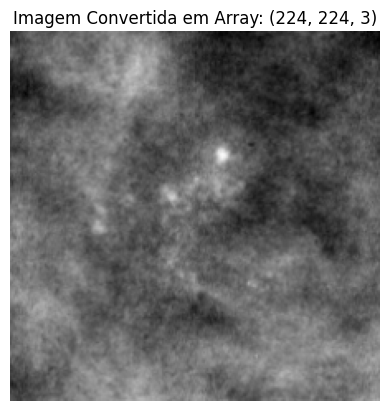


É esse array 'img_resized' que entra na Rede Neural!


In [15]:
from sklearn.model_selection import train_test_split

# 1. Map labels to integers (SageMaker requires float/int labels)
# MALIGNANT = 1, BENIGN = 0
class_map = {"MALIGNANT": 1, "BENIGN": 0, "BENIGN_WITHOUT_CALLBACK": 0}
df_clean['label_id'] = df_clean['pathology'].map(class_map)

# 2. Create Relative Paths
# SageMaker will see the 'jpeg' folder as root. We need paths like 'UID/image.jpg'
def make_relative_path(full_path):
    return os.path.relpath(full_path, jpeg_dir)

df_clean['s3_relative_path'] = df_clean['full_path'].apply(make_relative_path)

# 3. Split Data (Train 80% / Validation 20%)
# 'stratify' ensures equal balance of cancer/non-cancer in both sets
train_df, val_df = train_test_split(
    df_clean,
    test_size=0.2,
    stratify=df_clean['label_id'],
    random_state=42
)

# 4. Save .lst Files
# Format: Index \t Label \t Relative_Path
def save_lst_file(dataframe, filename):
    with open(filename, 'w') as f:
        for index, row in enumerate(dataframe.itertuples()):
            # Note: The index column in .lst must be unique per file
            line = f"{index}\t{row.label_id}\t{row.s3_relative_path}\n"
            f.write(line)
    print(f"Generated LST file: {filename} ({len(dataframe)} images)")

save_lst_file(train_df, 'train.lst')
save_lst_file(val_df, 'validation.lst')

## Upload to S3
Moves the data to the cloud.

In [ ]:
print(f"Uploading data to s3://{bucket}/{prefix} ...")

# 1. Upload Metadata (.lst files)
s3_train_lst = sess.upload_data('train.lst', bucket=bucket, key_prefix=f'{prefix}/metadata')
s3_val_lst = sess.upload_data('validation.lst', bucket=bucket, key_prefix=f'{prefix}/metadata')

# 2. Upload Images
# We upload the entire 'jpeg' directory. This might take a while.
# This ensures that relative paths in .lst (e.g., '1.3.6.../img.jpg') work correctly.
s3_images = sess.upload_data(jpeg_dir, bucket=bucket, key_prefix=f'{prefix}/images')

print("Upload complete!")
print(f"Images S3 Path: {s3_images}")
print(f"Train List: {s3_train_lst}")